# Training a multi-output network for age, gender and ethnicity detection on top of a pretrained model with Keras

#### How to train a single model (using a base pretrained model)capable of predicting three distinct type of outputs (age, gender, ethnicity) in shown in this notebook. The dataset is csv format the UTKface dataset

#### I have used Densenet169 here that gives an accuracy of 93% for gender and 87% for ethnicity and 81% for age. 

##### I have converted age from continuous to categorical to treat it as a classification problem, rather than a regression problem. This yields better result and less fluctuation when predicting in real time videos e.g. webcam

#### A final model and script to run the model on live webcam is available at:
https://github.com/arnabx007/age_gender_race_estimation


In [1]:
!pip install tensorflow_addons
import pandas as pd
import numpy as np
from tqdm import tqdm

import tensorflow.keras as keras 
import tensorflow as tf
import tensorflow_addons as tfa

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


# Reading the CSV

In [2]:

from google.colab import drive
drive.mount('/content/drive')


df = pd.read_csv('drive/MyDrive/datasets/soft_biometrics.csv')

# Replace the ethinicty values ith real_categories
ethnicity_mapping = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Hispanic"}
df['ethnicity'].replace(ethnicity_mapping, inplace=True)

# One-hot encode the ethinicty values
tmp = pd.get_dummies(df['ethnicity'], prefix='eth')
df = pd.concat([df, tmp], axis=1)


Mounted at /content/drive


Unique age values:  104


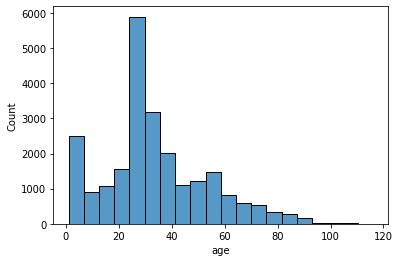

In [3]:
# Plotting the age values
print('Unique age values: ', df['age'].nunique())
sns.histplot(df['age'], bins=20)

In [4]:
# Coverting age to categorical values to solve it as a classififcation problem instead of regression problem
# If this is trained as a regression model, the age_values fluctuate too much during inference. 
def convert_age(age_value):
    
#     age_mapping = {0:'<10', 1:'11-15', 2:'16-20', 3:'21-25', 4:'26-30', 5:'31-35', 6:'36-42', 7:'43-50', 8:'51-60'. 9:'>60'}

    if age_value<=10:
        age_category = 0
    if 11<=age_value<=15:
        age_category = 1
    if 16<=age_value<=20:
        age_category = 2
    if 21<=age_value<=25:
        age_category = 3
    if 26<=age_value<=30:
        age_category = 4
    if 31<=age_value<=35:
        age_category = 5
    if 36<=age_value<=42:
        age_category = 6
    if 43<=age_value<=50:
        age_category = 7
    if 51<=age_value<=60:
        age_category = 8
    if age_value>60:
        age_category = 9
        
    return age_category

df['age_category'] = df['age'].apply(convert_age)
df

,age,ethnicity,gender,img_name,pixels,eth_Asian,eth_Black,eth_Hispanic,eth_Indian,eth_White,age_category
0,1,Asian,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...,1,0,0,0,0,0
1,1,Asian,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...,1,0,0,0,0,0
2,1,Asian,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...,1,0,0,0,0,0
3,1,Asian,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...,1,0,0,0,0,0
4,1,Asian,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
23700,99,White,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...,0,0,0,0,1,9
23701,99,Black,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...,0,1,0,0,0,9
23702,99,Asian,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...,1,0,0,0,0,9
23703,99,Asian,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...,1,0,0,0,0,9


In [5]:
# Dropping the images with ages less than 3 
to_drop = df[df['age']<=3].index
len(to_drop)
dfx = df.drop(to_drop, axis=0)
dfx['age_category'].value_counts()

# Randomly shuffle the dataset
dfx = dfx.sample(frac=1).reset_index(drop=True)

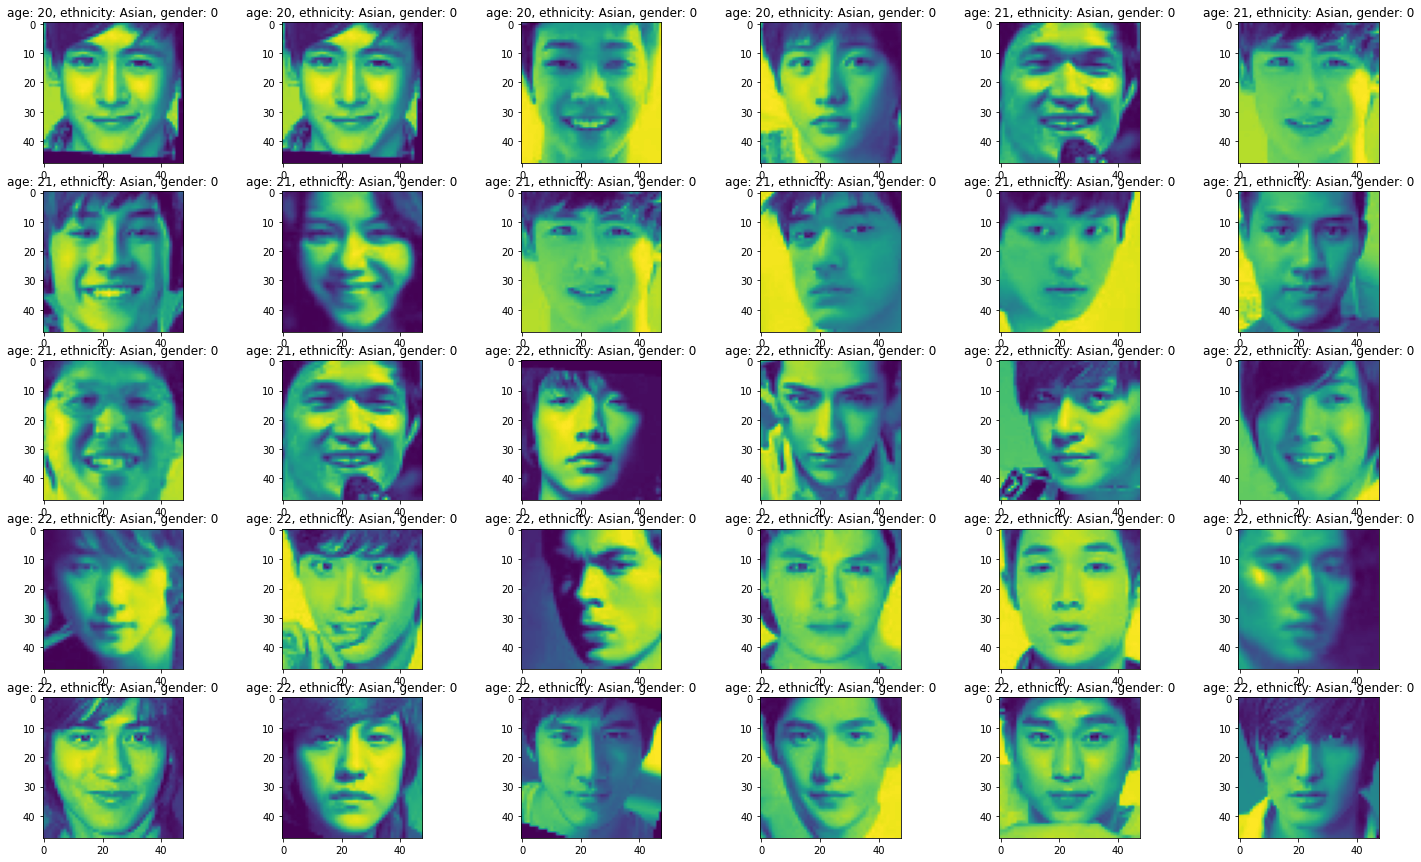

In [6]:
# Plotting some random images
eth = 'Asian'
age_min = 20
age_max = 50
gender = 0

fig = plt.figure(figsize=(25,15))

tmp = df[(df['ethnicity']==eth) & (df['age']>=age_min) & (df['age']<=age_max)& (df['gender']==gender)].index[:30]

j=0
for i in tmp:
    j+=1
    ax = fig.add_subplot(5,6,j)
    ax.imshow(np.array(df['pixels'][i].split(' '), dtype='int64').reshape(48,48))
    plt.title(f'age: {df.age[i]}, ethnicity: {df.ethnicity[i]}, gender: {df.gender[i]}')

In [7]:
# Create inputs with targets from dataframe
def create_inputs_targets(df):
    images = np.zeros((len(df), 48, 48))

    for i in tqdm(range(len(df))):
        images[i] = (np.array(df['pixels'][i].split(' '), dtype='int64').reshape(48,48)/255.0)
     
    age_labels = np.array(df['age_category'])
    gender_labels = np.array(df['gender'])
    ethnicity_labels = np.array(df[['eth_Asian', 'eth_Black', 'eth_Hispanic', 'eth_Indian', 'eth_White']])
    
    return images, [age_labels, gender_labels, ethnicity_labels]

In [8]:
# Splitting the dataframe into 80-20% training and validation dataframes
validation_data_indices = dfx.sample(frac=0.2).index
validation_df = df.loc[validation_data_indices, :].reset_index(drop=True)

train_df = dfx.drop(validation_data_indices, axis=0).reset_index(drop=True)

x_train, y_train = create_inputs_targets(train_df)
x_val, y_val = create_inputs_targets(validation_df)

print('Training data shape:', x_train.shape, y_train[0].shape, y_train[1].shape, y_train[2].shape)
print('Validation data shape:', x_val.shape, y_val[0].shape, y_val[1].shape, y_val[2].shape)

100%|██████████| 4362/4362 [00:02<00:00, 1920.10it/s]

Training data shape: (17449, 48, 48) (17449,) (17449,) (17449, 5)
Validation data shape: (4362, 48, 48) (4362,) (4362,) (4362, 5)


# Building The Model

In [9]:
# The model will be composed of three heads, one for each target: age, gender and race.
# I am using DenseNet169 as the base pretrained model here

class create_model():
    
    def __init__(self, im_width=48, im_height=48):
        
        self.im_height = im_height
        self.im_width = im_width
        
        # Initializing the base pretrained model
        self.base = keras.applications.DenseNet169(weights=None, include_top=False, input_shape=(self.im_height, self.im_width, 1))
        self.base.trainable=True
        self.base_output_layer = self.base.output

    # Making gender branch for gender prediction on top of the base model 
    def gender_branch(self):
        
        # Passing the output layer of the base preatined model to a flattening (global average pooling) layer
        x = keras.layers.GlobalAveragePooling2D()(self.base_output_layer)
        x = keras.layers.Dense(128, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(32, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(1, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros())(x)
        
        x = keras.layers.Activation('sigmoid', name='gender_output')(x)
        
        return x    
   
    # Making branch for age prediction on top of the base model 
    def age_branch(self): 
        
        # Passing the output layer of the base preatined model to a flattening (global average pooling) layer
        x = keras.layers.GlobalAveragePooling2D()(self.base_output_layer)
        x = keras.layers.Dense(128, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(32, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(10, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros())(x)
        
        x = keras.layers.Activation('softmax', name='age_output')(x)
        
        return x
    
    # Making branch for ethnicity prediction on top of the base model 
    def ethnicity_branch(self): 
        
        # Passing the output layer of the base preatined model to a flattening (global average pooling) layer
        x = keras.layers.GlobalAveragePooling2D()(self.base_output_layer)
        x = keras.layers.Dense(128, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(32, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(5, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros())(x)
        
        x = keras.layers.Activation('softmax', name='ethnicity_output')(x)
        
        return x  
    
    def full_model(self):
       
        age_branch = self.age_branch()
        gender_branch = self.gender_branch()
        ethnicity_branch = self.ethnicity_branch() 
        
        model = keras.models.Model(inputs= self.base.input,
                     outputs = [age_branch, gender_branch, ethnicity_branch],
                     name="FACE_NET")        
        return model
    
m = create_model(im_width=48, im_height=48)
model = m.full_model()
# model.summary()

# Model Training

In [10]:
losses = {'age_output': keras.losses.SparseCategoricalCrossentropy(), 
          'gender_output': keras.losses.BinaryCrossentropy(),
          'ethnicity_output': keras.losses.CategoricalCrossentropy()}

#Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs. 
#The loss value that will be minimized by the model will then be the weighted sum of all individual losses, weighted by the loss_weights coefficients. 
loss_weights = {'age_output': 1.0, 
                'gender_output': 0.5,
                'ethnicity_output':0.5}

metrices = {'age_output': [keras.metrics.SparseTopKCategoricalAccuracy(k=1)], 
            'gender_output': [keras.metrics.BinaryAccuracy()],
            'ethnicity_output': [keras.metrics.CategoricalAccuracy()]}

init_lr = 1e-4
epochs = 80

# Decay based on the learning rate divided by the number of epochs, to slowly decrease the learning rate over the epochs.
model.compile(optimizer = keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs), 
              loss = losses,
              loss_weights = loss_weights,
              metrics=metrices)

my_callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=5, mode='min', restore_best_weights=True)]

hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=32, callbacks=my_callbacks)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/80
546/546 [==============================] - 151s 179ms/step - loss: 2.9218 - age_output_loss: 2.0348 - gender_output_loss: 0.5141 - ethnicity_output_loss: 1.2600 - age_output_sparse_top_k_categorical_accuracy: 0.2596 - gender_output_binary_accuracy: 0.7424 - ethnicity_output_categorical_accuracy: 0.5128 - val_loss: 3.0953 - val_age_output_loss: 2.1078 - val_gender_output_loss: 0.6067 - val_ethnicity_output_loss: 1.3682 - val_age_output_sparse_top_k_categorical_accuracy: 0.2359 - val_gender_output_binary_accuracy: 0.6641 - val_ethnicity_output_categorical_accuracy: 0.4516
Epoch 2/80
546/546 [==============================] - 90s 165ms/step - loss: 2.4470 - age_output_loss: 1.7676 - gender_output_loss: 0.3582 - ethnicity_output_loss: 1.0005 - age_output_sparse_top_k_categorical_accuracy: 0.3435 - gender_output_binary_accuracy: 0.8444 - ethnicity_output_categorical_accuracy: 0.6320 - val_loss: 2.6247 - val_age_output_loss: 1.8596 - val_gender_output_loss: 0.3889 - val_ethnicity_

# Loss and Accuracy Plots

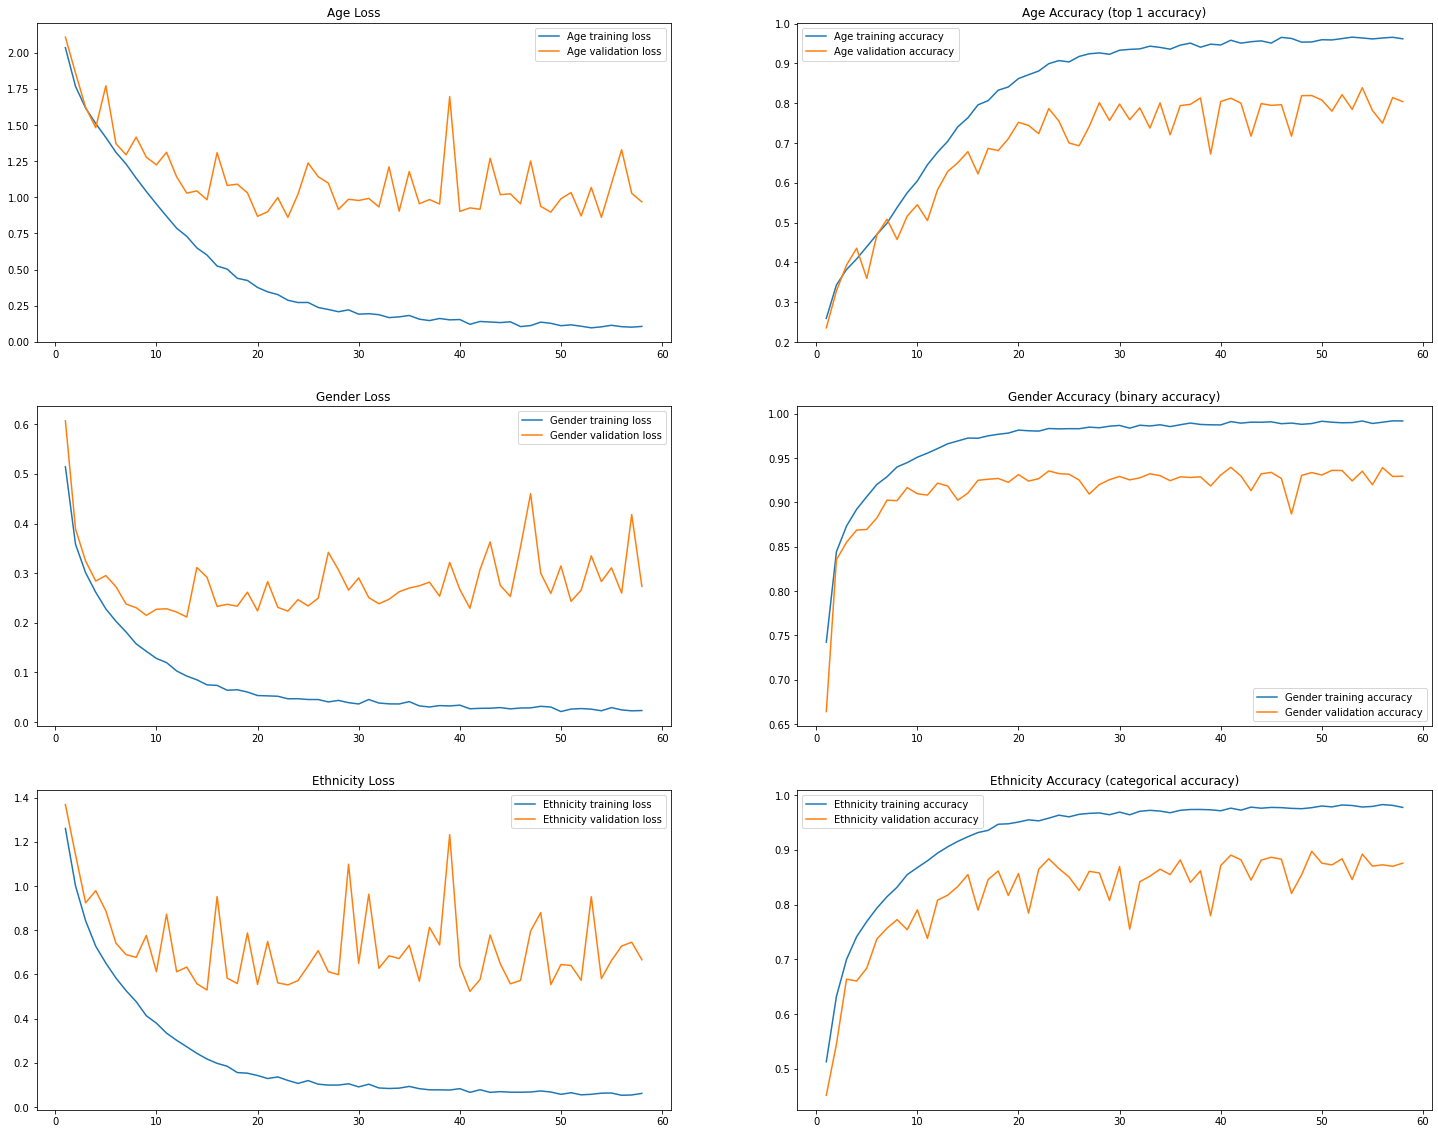

In [11]:
fig = plt.figure(figsize=(25,20))
width = 2
height = 3

epochs = [i+1 for i in range(len(hist.history['loss']))]

# Age losses
ax = fig.add_subplot(height,width,1)
sns.lineplot(x = epochs, y = hist.history['age_output_loss'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_age_output_loss'], ax=ax)
plt.title('Age Loss')
plt.legend(['Age training loss', 'Age validation loss'])

# Age accuracy
ax = fig.add_subplot(height,width,2)
sns.lineplot(x = epochs, y = hist.history['age_output_sparse_top_k_categorical_accuracy'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_age_output_sparse_top_k_categorical_accuracy'], ax=ax)
plt.title('Age Accuracy (top 1 accuracy)')
plt.legend(['Age training accuracy', 'Age validation accuracy'])

# Gender losses
ax = fig.add_subplot(height,width,3)
sns.lineplot(x = epochs, y = hist.history['gender_output_loss'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_gender_output_loss'], ax=ax)
plt.title('Gender Loss')
plt.legend(['Gender training loss', 'Gender validation loss'])

# Gender accuracy
ax = fig.add_subplot(height,width,4)
sns.lineplot(x = epochs, y = hist.history['gender_output_binary_accuracy'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_gender_output_binary_accuracy'], ax=ax)
plt.title('Gender Accuracy (binary accuracy)')
plt.legend(['Gender training accuracy', 'Gender validation accuracy'])

ax = fig.add_subplot(height,width,5)
sns.lineplot(x = epochs, y = hist.history['ethnicity_output_loss'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_ethnicity_output_loss'], ax=ax)
plt.title('Ethnicity Loss')
plt.legend(['Ethnicity training loss', 'Ethnicity validation loss'])

ax = fig.add_subplot(height,width,6)
sns.lineplot(x = epochs, y = hist.history['ethnicity_output_categorical_accuracy'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_ethnicity_output_categorical_accuracy'], ax=ax)
plt.title('Ethnicity Accuracy (categorical accuracy)')
plt.legend(['Ethnicity training accuracy', 'Ethnicity validation accuracy'])

# Classification reports for each feature on the Validation set

In [12]:
predictions = model.predict(x_val)

In [13]:
age_true = validation_df['age_category']
age_true = np.array(age_true)

age_pred = [np.argmax(predictions[0][i]) for i in range(len(x_val))]

age_map = {0:'<10', 1:'11-15', 2:'16-20', 3:'21-25', 4:'26-30', 5:'31-35', 6:'36-42', 7:'43-50', 8:'51-60', 9:'>60'}
reverse_age_map = {y:x for x,y in age_map.items()}

age_report = classification_report(age_true, age_pred, target_names=reverse_age_map.keys())
print(age_report)

              precision    recall  f1-score   support

         <10       0.97      0.89      0.93       572
       11-15       0.74      0.83      0.78       124
       16-20       0.73      0.82      0.77       207
       21-25       0.83      0.79      0.81       561
       26-30       0.86      0.76      0.81      1015
       31-35       0.68      0.77      0.72       477
       36-42       0.90      0.61      0.73       459
       43-50       0.75      0.73      0.74       330
       51-60       0.60      0.86      0.71       410
         >60       0.66      0.88      0.75       207

    accuracy                           0.78      4362
   macro avg       0.77      0.79      0.78      4362
weighted avg       0.80      0.78      0.79      4362



In [14]:
gender_true = validation_df['gender']
gender_true = np.array(gender_true)

gender_pred = [round(predictions[1][i][0]) for i in range(len(x_val))]

gender_report = classification_report(gender_true, gender_pred, target_names={'male':0, 'female':1}.keys())
print(gender_report)

              precision    recall  f1-score   support

        male       0.90      0.96      0.93      2239
      female       0.96      0.88      0.92      2123

    accuracy                           0.92      4362
   macro avg       0.93      0.92      0.92      4362
weighted avg       0.93      0.92      0.92      4362



In [15]:
eth_true = validation_df[['eth_Asian','eth_Black','eth_Hispanic','eth_Indian','eth_White']].values
eth_true = [np.argmax(eth_true[i]) for i in range(len(eth_true))]

eth_pred = [np.argmax(predictions[2][i]) for i in range(len(x_val))]

# This eth map is not the same as the ethnicity_mapping dict. 
# When ethinicity data was one hot encoded pandas encoded it in alphabetical order

eth_map = {0: 'Asian', 1: 'Black', 2: 'Hispanic', 3: 'Indian', 4: 'White'}
reverse_eth_map = {y:x for x,y in eth_map.items()}

eth_report = classification_report(eth_true, eth_pred, target_names=reverse_eth_map.keys())
print(eth_report)

              precision    recall  f1-score   support

       Asian       0.97      0.64      0.77       658
       Black       0.91      0.93      0.92       859
    Hispanic       0.92      0.45      0.60       337
      Indian       0.89      0.81      0.85       770
       White       0.77      0.97      0.86      1738

    accuracy                           0.85      4362
   macro avg       0.89      0.76      0.80      4362
weighted avg       0.86      0.85      0.84      4362



# Prediction on Random images from the dataframe

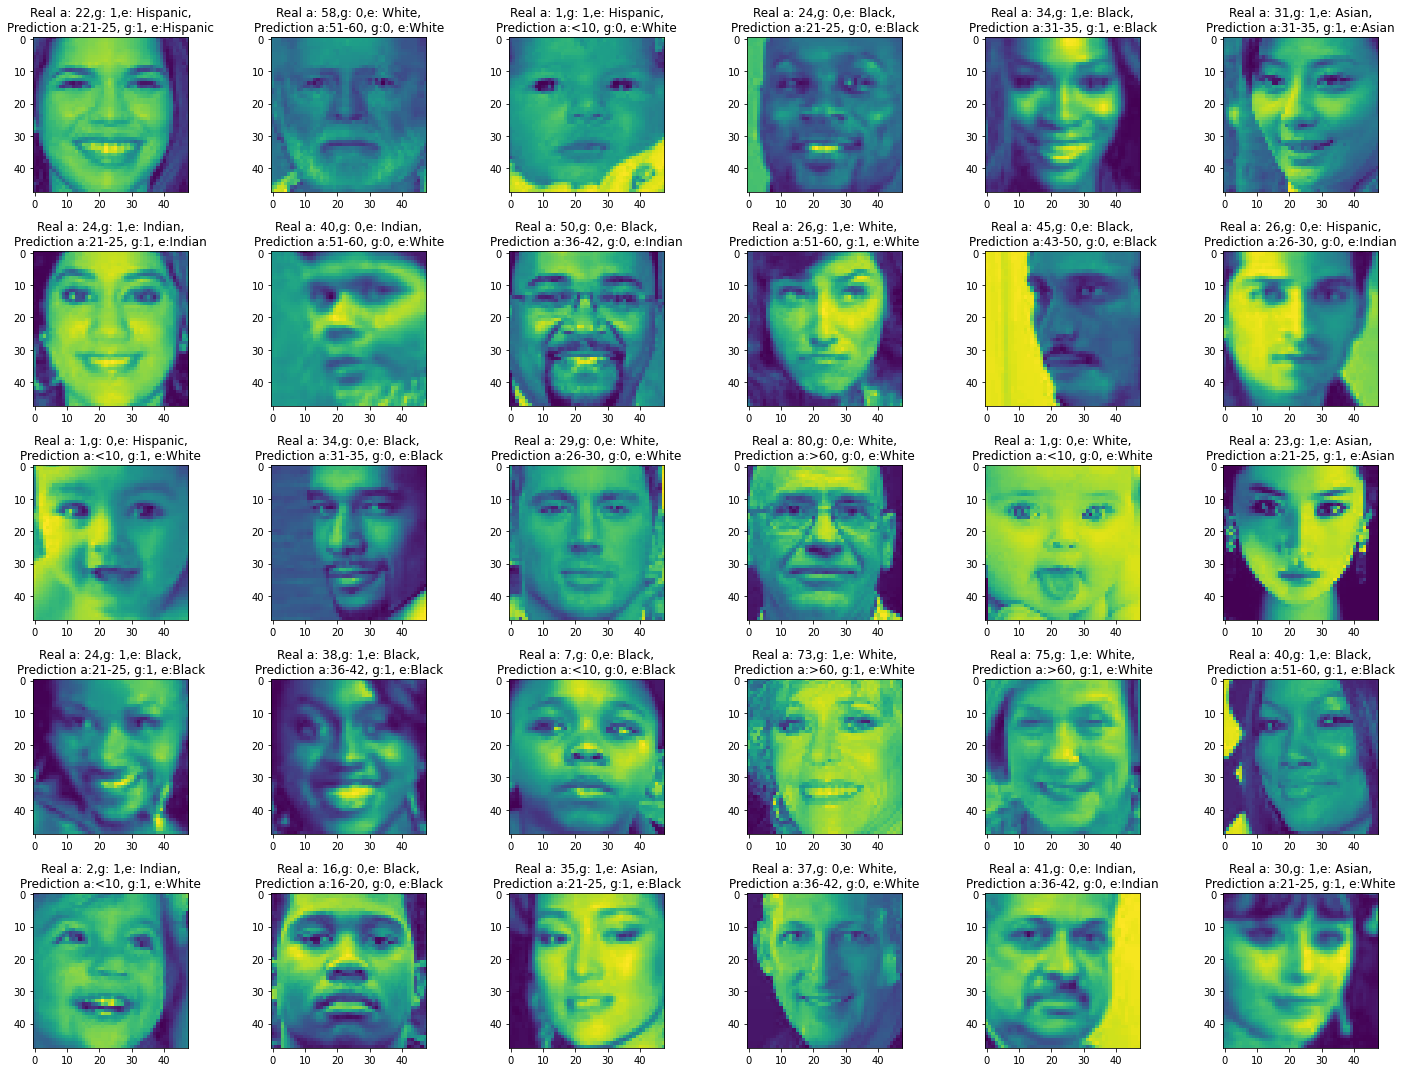

In [16]:
# Plotting some random images
random_indices = [np.random.randint(low=0, high=len(df)) for i in range(30)]

fig = plt.figure(figsize=(20,15))

for i in range(len(random_indices)):
    ax = fig.add_subplot(5,6,i+1)
    index = random_indices[i]
    img = df['pixels'][index]
    img = np.array(img.split(' '), dtype='int64').reshape(48,48)/255.0
    ax.imshow(img)
    
    output = model.predict(np.reshape(img, (1,48,48)))
    
    age, gender, eth = np.argmax(output[0]), round(output[1][0][0]), np.argmax(output[2])
    age = age_map[age]
    ethnicity = eth_map[eth]
    
    plt.title(f'Real a: {df.age[index]},g: {df.gender[index]},e: {df.ethnicity[index]},\nPrediction a:{age}, g:{gender}, e:{ethnicity}')
    
fig.tight_layout()

In [17]:
# model.save('./face_net.h5')